In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
STEPS = 50
STEP = 1/STEPS
CONST = (3 * np.cosh(np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) - 3 / (np.pi**2 + 1)) / np.sinh(np.sqrt((np.pi**2 + 1) / 3))
EPSILON = 1/100000 # точность порядка точного метода ДБСПФ

In [4]:
# двойное быстрое синус преобразование
def vector_dst(vector):
  matrix_x = np.stack([vector for _ in range(len(vector))])
  matrix_kn = np.arange(1,len(vector)+1).reshape(1,len(vector)) * np.arange(1,len(vector)+1).reshape(len(vector), 1)
  const = np.pi/(len(vector)+1)
  matrix_fi = matrix_kn*const
  matrix_sin = np.sin(matrix_fi)
  return np.sum(matrix_x * matrix_sin, axis = 1)
def dst(matrix):
  #return np.round(np.apply_along_axis(vector_dst, 0, matrix), 4)
  return np.apply_along_axis(vector_dst, 0, matrix)

# обратное
def vector_idst(vector):
  const = 2/(len(vector)+1)
  return const*vector_dst(vector)
def idst(matrix):
  #return np.round(np.apply_along_axis(vector_idst, 0, matrix), 4)
  return np.apply_along_axis(vector_idst, 0, matrix)

In [5]:
# правая функция уравнения 
def right_function(steps=STEPS, step = STEP, first_index = 0):
  right_f = np.zeros((steps-1, steps-1))
  for id_y in range(first_index, steps-1):
      for id_x in range(first_index, steps-1):
        right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x+1) * step)
  return right_f

In [8]:
# реализует аналитическое решение на заданной сетке
def get_analytical_Uxy(steps=STEPS, step = STEP):
  U_x_y = np.zeros((steps+1, steps+1))
  for id_x in range(0, steps):
    for id_y in range(0, steps):
      U_x_y[id_x, id_y] = np.sin(np.pi * (id_x) * step) * (-3 * np.cosh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) + 3 / (np.pi**2 + 1) + CONST * np.sinh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)))
  return U_x_y

# решение методом ДБСП
def get_double_fast_sine_conversion_Uxy(steps=STEPS, step = STEP):
  right_f = right_function(steps, step)
  start_time = time.clock()
  first_sine_conversion = idst(idst(right_f.T).T)/step**2
  own_lambda = np.zeros((steps-1, steps-1))
  for m in range(0, steps-1):
      for k in range(0, steps-1):
          own_lambda[k, m] = step**2 / (4 * (np.sin(np.pi * (k+1) * step * 0.5))**2 + 12 * (np.sin(np.pi * (m+1) * step * 0.5))**2 + step**2)
  second_sine_conversion  = dst(dst((own_lambda * first_sine_conversion).T).T)
  end_time = time.clock()
  sin_conv_with_zeros = np.zeros((steps + 1, steps + 1))
  for id_y in range(0, steps-1):
      for id_x in range(0, steps-1):
          sin_conv_with_zeros[id_x + 1, id_y + 1] = second_sine_conversion[id_x, id_y]
  return sin_conv_with_zeros, (end_time - start_time)

# решение методом Якоби
def Jacobi_method(U_x_y, steps=STEPS, step = STEP, epsilon = EPSILON):
  #U_x_y = get_analytical_Uxy(steps, step)
  time_start = time.clock()
  right_f = np.zeros((steps+1, steps+1))
  for id_y in range(1, steps):
      for id_x in range(1, steps):
          right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x) * step)
  U_Jacobi = np.zeros((steps+1, steps+1))
  iterations = 0
  U_Jacobi_prev = U_Jacobi
  while np.amax(U_x_y - U_Jacobi) > epsilon :
    print(iterations)
    for id_x in range(1, steps):
        for id_y in range(1, steps):
            U_Jacobi[id_x, id_y] = (right_f[id_x, id_y] + U_Jacobi_prev[id_x - 1, id_y] + U_Jacobi_prev[id_x + 1, id_y] + 3 * U_Jacobi_prev[id_x, id_y - 1] + 3 * U_Jacobi_prev[id_x, id_y + 1]) / (8 + step**2)
    iterations +=1
    U_Jacobi_prev = U_Jacobi
  time_end = time.clock()
  return U_Jacobi, (time_end - time_start), iterations

In [9]:
def norm_matrix_1(u):
  # максимум суммы строк 
  return np.amax(np.sum(np.absolute(u), axis = 0))
def norm_matrix_inf(u):
  # максимум суммы столбцов 
  return np.amax(np.sum(np.absolute(u), axis = 1))

In [19]:
# рисунок решения в 3D
def get_draw(u_x_y, title, grid_step):
  X, Y = np.mgrid[0:1:grid_step, 0:1:grid_step]
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X, Y, u_x_y, cmap='cividis')
  ax.set_title(title)
  ax.legend()

No handles with labels found to put in legend.


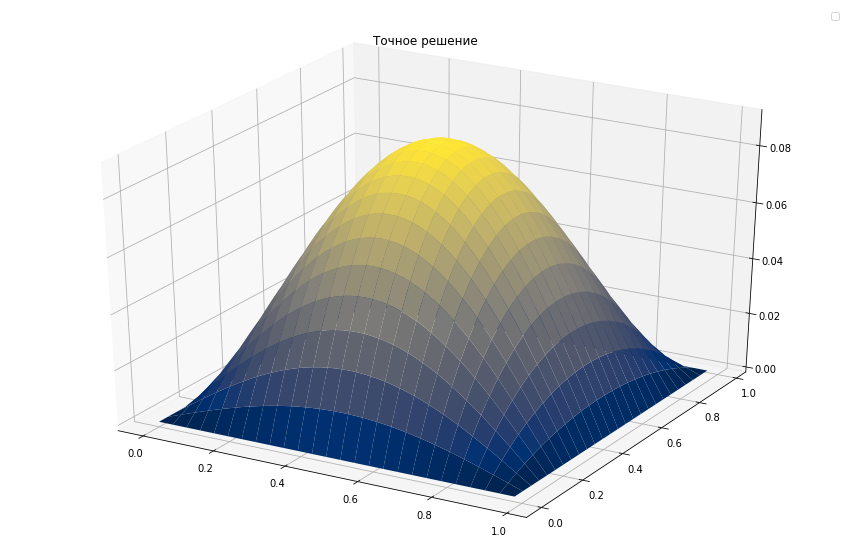

In [20]:
analytical_Uxy = get_analytical_Uxy()
get_draw(analytical_Uxy, "Точное решение", 1/(STEPS+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
No handles with labels found to put in legend.


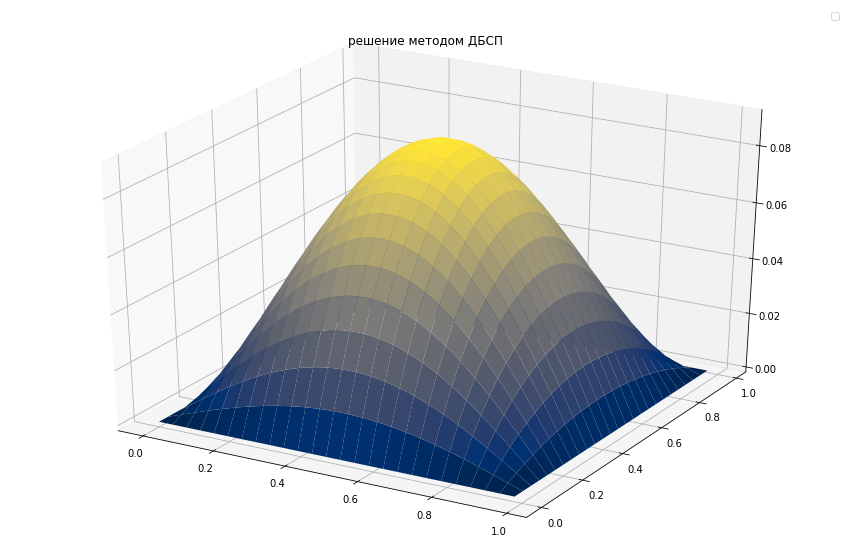

In [21]:
sin_conv, del_time = get_double_fast_sine_conversion_Uxy()
get_draw(sin_conv, "решение методом ДБСП", 1/(STEPS+1))

No handles with labels found to put in legend.


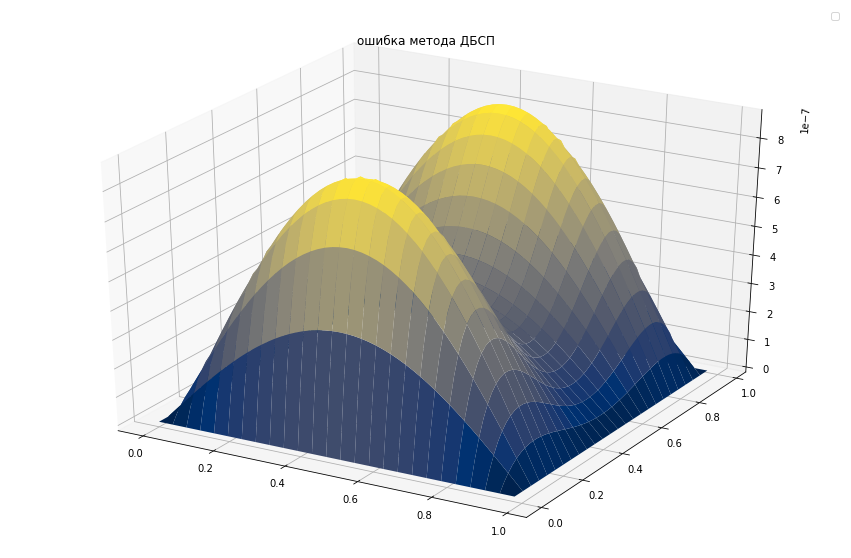

In [22]:
get_draw(analytical_Uxy - sin_conv, "ошибка метода ДБСП", 1/(STEPS+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
No handles with labels found to put in legend.


2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259


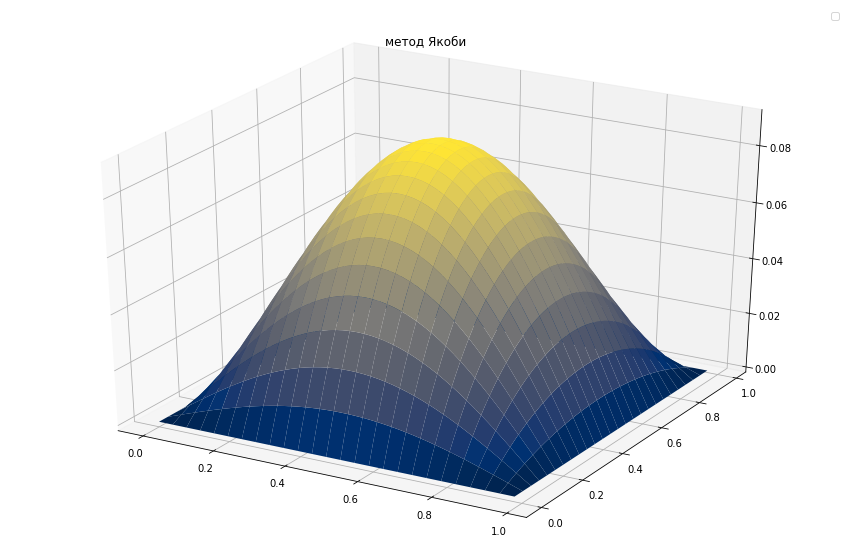

In [23]:
u_jacobi, jacobi_time, iterations = Jacobi_method(sin_conv)
get_draw(u_jacobi, "метод Якоби", 1/(STEPS+1))

No handles with labels found to put in legend.


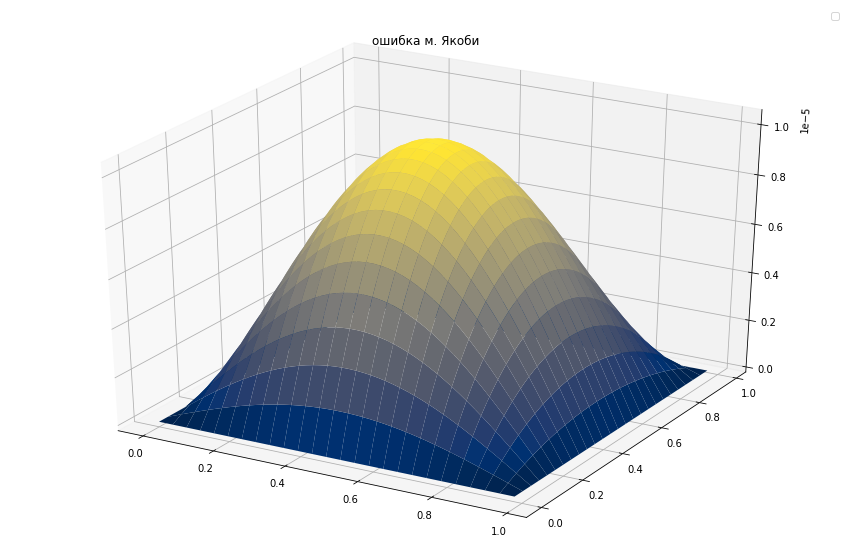

In [24]:
get_draw(analytical_Uxy - u_jacobi, "ошибка м. Якоби", 1/(STEPS+1))

In [10]:
array_sine_time = []
array_jacobi_time = []

array_jacobi_iterations = []

array_u_sine = []
array_U_jacobi = []

norm_diff_sine_1 = []
norm_diff_sine_inf = []

norm_diff_jacobi_1 = []
norm_diff_jacobi_inf = []

array_n = [10, 25, 50, 75, 100, 150]

for steps in array_n:
  step = 1/steps
  U_x_y = get_analytical_Uxy(steps, step)
  U_sine, sine_time = get_double_fast_sine_conversion_Uxy(steps, step)
  array_u_sine.append(U_sine)
  array_sine_time.append(sine_time)
  norm_diff_sine_1.append(norm_matrix_1(U_x_y-U_sine))
  norm_diff_sine_inf.append(norm_matrix_inf(U_x_y-U_sine))

  U_jacobi, jacobi_time, iterations = Jacobi_method(U_sine, steps, step) # EPSILON = 1/100000
  array_U_jacobi.append(U_jacobi)
  array_jacobi_time.append(jacobi_time)
  array_jacobi_iterations.append(iterations)
  norm_diff_jacobi_1.append(norm_matrix_1(U_x_y-U_jacobi))
  norm_diff_jacobi_inf.append(norm_matrix_inf(U_x_y-U_jacobi))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Выходные данные были обрезаны до нескольких последних строк (5000).
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501
15502
15503
15

In [11]:
import pandas as pd
pd.DataFrame({"Разбиение": array_n,
              "ДБСП (сек)": array_sine_time,
              "L1 разности ДБСП": norm_diff_sine_1,
              "L_inf разности ДБСП": norm_diff_sine_inf,
              "м.Якоби (сек)": array_jacobi_time,
              "L1 разности Якоби": norm_diff_jacobi_1,
              "L_inf разности Якоби": norm_diff_jacobi_inf,
              "итер м.Якоби": array_jacobi_iterations})

,Разбиение,ДБСП (сек),L1 разности ДБСП,L_inf разности ДБСП,м.Якоби (сек),L1 разности Якоби,L_inf разности Якоби,итер м.Якоби
0,10,0.005031,0.000131,0.000139,0.063498,0.000171,0.000198,90
1,25,0.049106,0.000055,0.000060,1.399520,0.000181,0.000217,565
2,50,0.051106,0.000028,0.000030,17.437306,0.000330,0.000349,2260
3,75,0.112637,0.000019,0.000020,82.665690,0.000485,0.000497,5087
4,100,0.249606,0.000014,0.000015,256.219996,0.000642,0.000651,9044
5,150,0.639772,0.000009,0.000010,1277.312447,0.000959,0.000965,20349


In [29]:
# посчитаем по правилу Рунге оценку погрешности и фактическую скорость сходимости (2 или меньше). возьмем при n = 50 и n = 100

u_sin_50 = array_u_sine[2]
u_sin_100 = array_u_sine[4]

U_jacobi_50 = array_U_jacobi[2]
U_jacobi_100 = array_U_jacobi[4]

p = np.log2((np.absolute(norm_matrix_1(U_jacobi_50) - norm_matrix_1(U_jacobi_100))/np.absolute(norm_matrix_1(u_sin_100) - norm_matrix_1(U_jacobi_50)))+1)
print(f"порядок точности p = {p}")

порядок точности p = 0.9998408340122378


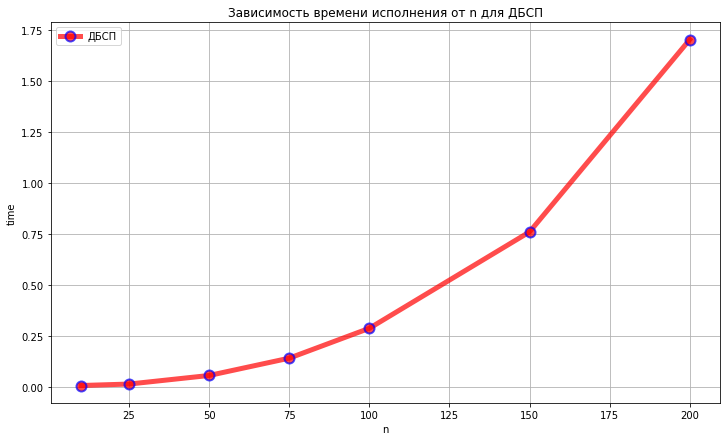

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_sine_time, 'o-r', alpha=0.7, label="ДБСП", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для ДБСП")
plt.legend()
plt.grid(True)

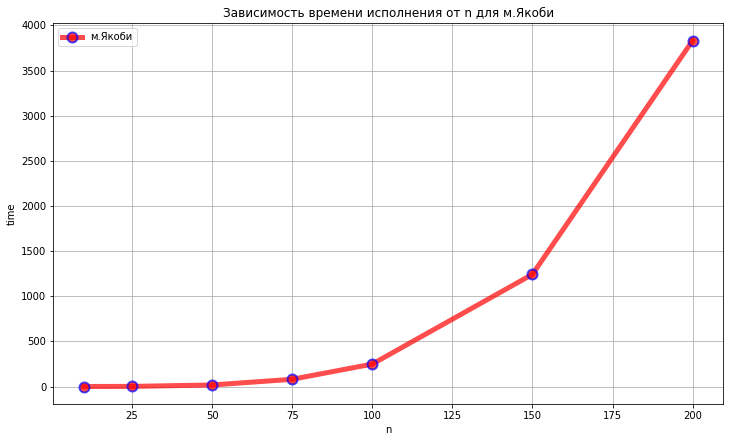

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_jacobi_time, 'o-r', alpha=0.7, label="м.Якоби", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для м.Якоби")
plt.legend()
plt.grid(True)